# Multitaper with gaps 

It is possible to compute the multitaper spectrum on data that contain large gaps. In this notebook we demo the capabilities of this functionality.

┌ Info: Precompiling Multitaper [a81958ac-9ec9-4086-814d-3ae87249a5e8]
└ @ Base loading.jl:1278


######################################################################### 100.0%                                 34.7%#                                        48.9%                          60.9%##             85.9%


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


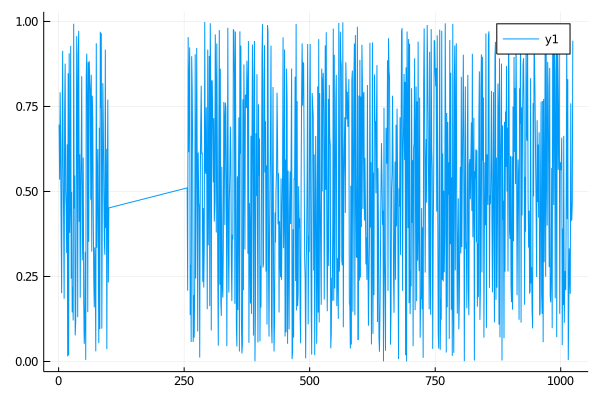

In [1]:
# Bring in the testfile
using DelimitedFiles, Multitaper, Plots

dat = readdlm("./data/temp.txt", ',')

tt = dat[:,1]
xx = dat[:,2]

plot(tt,xx)

In [7]:
x = randn(40); tt = vcat(collect(1:30),collect(40:50))
mdmultispec(tt,x)

LoadError: InexactError: Int64(8.75609756097561)

We're going to make a set of generalized Slepian tapers having a gap. To see these, use


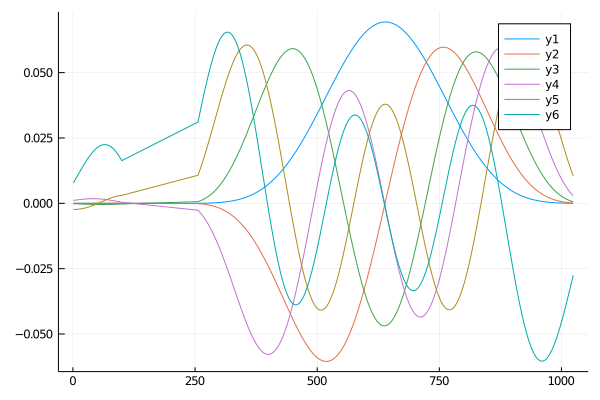

In [2]:
NW = 4.0
W = NW/length(tt)
egvals,sleps = mdslepian(W, 6, tt)
plot(tt,sleps)

There is one gap in the data between t = 101 and t = 256. To do the spectral analysis, use

In [3]:
out = mdmultispec(tt,xx,alpha=0.99)

MtSpec{Ecoef,Array{Float64,1},Nothing}(0.0:0.0011507479861910242:0.5005753739930955, [0.045757662974367036, 0.096201869303705, 0.09151532594873409, 0.08748768699520715, 0.08014403793020489, 0.0727102947422884, 0.08258829122622105, 0.08380014974328585, 0.09400875862844935, 0.07252924236714771  …  0.2505363826116613, 0.1875410004711294, 0.19934120667386077, 0.1836189987818103, 0.14565610885883232, 0.13580424778417852, 0.1293182864247158, 0.1395702616312291, 0.1664040092175493, 0.09202992618124456], nothing, MtParams(5.0, 9, 869, 1.0, 870, 1, nothing), Ecoef(Complex{Float64}[-0.04811928064655522 + 0.03258918601576732im -0.12676219157668692 - 0.0035030238604773444im … 0.026937868771009132 - 0.08718850841886387im 0.06289338727325007 + 0.023256551863611787im; -0.07346660112492796 + 0.0im -0.13897516005643823 + 0.0im … -0.09537781911807279 + 0.0im -0.05675782384939235 + 0.0im; … ; 0.15964763059781945 + 0.17248113471704554im 0.0431633418922383 - 0.31701157547893033im … 0.14192809960316033 + 0.

The first output will simply be the estimated spectrum. By default this code computes the F-test statistic as well.

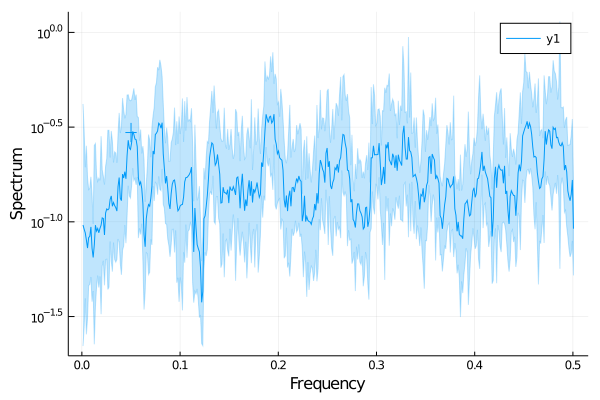

In [4]:
plot(out)

These are the p-values for the F-test statistic. I've scattered it where there are significant line components as indicated by the F-test result. The alpha value for the test here is small, set to the reciprocal of the length of the series.

Significance level set to 0.998849252013809.


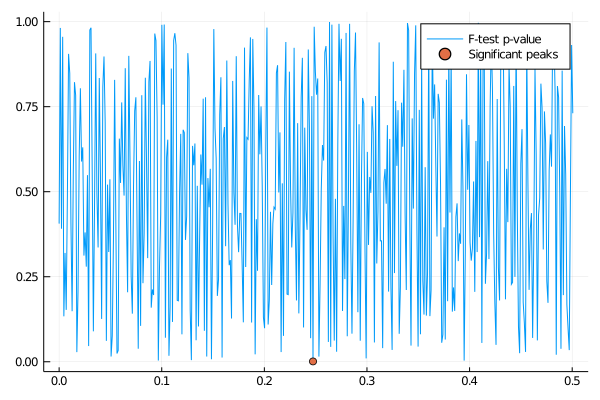

In [5]:
plot(out.f, out.Fpval, label = "F-test p-value")
ind = findall(out.Fpval .< 1/length(tt))
println("Significance level set to $(1.0-1/length(tt)).")
scatter!(out.f[ind], out.Fpval[ind], label="Significant peaks")

There is nothing deep about this example, in that the data were simply white noise with added gaps, so there is not much to be said about this result. 

# References

Chave, Alan D. "A multitaper spectral estimator for time-series with missing data." Geophysical Journal International 218.3 (2019): 2165-2178.
